# Input Capture Peripheral Example

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pioemu import conditions, emulate, State
from adafruit_pioasm import Program
from collections import deque

## Introduction

This notebook demonstrates the emulation of a PIO program for the Raspberry Pi Foundation's RP2040 Microcontroller. The PIO program is an input capture device for measuring pulse width

## PIO Program

The program below measures the width of low-pulses, but it has the following limitations:
- High-pulses must be at list 6 clock cycles
- Low-pulses are measured in even numbers only

Try changing it and observe the results!

In [33]:
asm = Program('''
.program input_capture
    set x, 1
    wait 0 pin 0         ;Wait for falling edge
public start_capture:
    mov x, !x            ;Set X to -2
do_count:                ;Count cycles until rising edge
    jmp pin end_capture
    jmp x-- do_count     ; Decrement X
public end_capture:
    mov x, !x            ;Negate X again
    in x, 31
    in null, 1           ;Multiply by 2
    push noblock
''')

program = asm.assembled
print([hex(x) for x in program])

['0xe021', '0x2020', '0xa029', '0xc5', '0x43', '0xa029', '0x403f', '0x4061', '0x8000']


## Emulation

In [30]:
class Pwm:
    def __init__(self, widths):
        self.xs = np.cumsum(widths) #Calculate transition times
        self.xs = np.append(self.xs, 2**62 - 1)   #Make sure we don't exceed the last transition
        self.val = 0
        self.mask = 1<<0 #For bit zero
        self.i = 0
    def next(self, state:State):
        if state.clock >= self.xs[self.i]:
            self.val ^= self.mask #Toggle value
            self.i += 1
        return self.val

init = State(pin_directions=0x00)

trace = [
    (state.clock, state.pin_values, state.program_counter, state.receive_fifo.pop() if state.receive_fifo else None)
    for _, state in emulate(program, 
                    stop_when=conditions.clock_cycles_reached(120),
                    initial_state = init,
                    input_source=Pwm(list(range(20))).next,
                    shift_isr_right = False,
                   )
]

## Output on Pin GP0

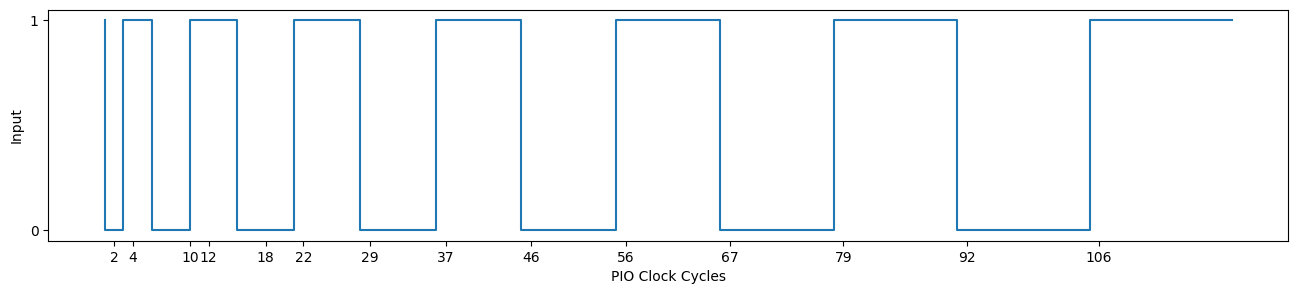

In [31]:
t = [x[0] for x in trace]

execution = [x[2] for x in trace]
crossref = {value:key for key,value in asm.public_labels.items()}
execution = [crossref[x] if x in crossref else x for x in execution]

def binary_plot(names):
    n = len(names)
    fig, axes = plt.subplots(n,1,sharex=True,sharey=True, figsize=(16,3))
    if not isinstance(axes, list):
        axes = [axes]
    for i in range(n):
        axes[i].step(t,  [1 if x[1]&(1<<i) else 0 for x in trace])
        axes[i].set_ylabel(names[i])
    axes[0].set_xlabel('PIO Clock Cycles')
    plt.yticks([0,1])
    plt.xticks([n for n,e in zip(t,execution) if type(e) is type('')]) #Only label the named transitions

binary_plot(['Input'])

In [29]:
captures = [x[3] for x in trace if x[3] is not None]
print(captures)

[2, 2, 4, 8, 10, 12]
